**About this project**.
In this project, we build a convolutional neural network that can classify images of hand-written digits. The model will get trained on the QMNIST dataset, an extension of the MNIST dataset, and validated on a small portion of it. The convolutional neural network is implemented with Pytorch. We gauge the accuracy of our model taking some black-white images of handwritten digits from some URL addresses. The code used in this project is mostly taken from the Udemy Course "Pytorch for Deep Learning and Computer Vision", taught by Rayan Slim. This code has been written in Google Colaboratory.

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # useful to run the code on GPU

In [0]:
transformation = transforms.Compose([transforms.Resize((28,28)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5, ))                                     
                                     ])

# The previous transformation converts the dataset into 28 x 28 pixels images, it stores them as tensors and finally normalizes them

In [4]:
# download the QMNIST dataset and split it into training and test dataset

train_dt = datasets.QMNIST(root = './data', download = True, train=True, transform=transformation)
test_dt = datasets.QMNIST(root = './data', download = True, train=False, transform=transformation)


Processing...



Processing...


In [0]:
training_loader = torch.utils.data.DataLoader(train_dt, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_dt, batch_size=100, shuffle=False)

In [0]:
# Function to convert the image to an array

def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # clone the image, detach the tensor from the graph and convert it to a numpy array
    image = image.transpose(1, 2, 0) # we swap the image dimensions such that it is no more 28 x 28 x 1, but 1 x 28 x 28 
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # denormalize image, multiplying by the std and adding the mean
    image = image.clip(0, 1) # clip would translate the minimum to 0 and the maximum to 1 
    return image

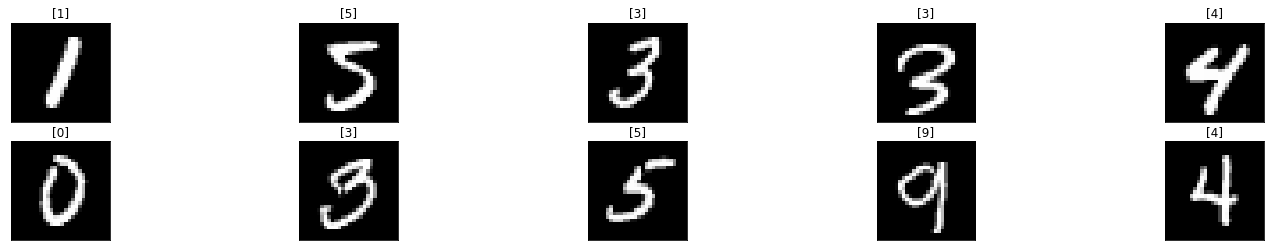

In [7]:
dataiter = iter(training_loader) # makes the training_loader an iterable 
images, labels = dataiter.next() # grabs the single batch of the training data
fig = plt.figure(figsize=(25, 4)) 

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [0]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.dropout1 = nn.Dropout(0.5)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [9]:
model = LeNet().to(device) # the model will be run on GPU 
model

LeNet(
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss() # the cross entropy loss function is chosen
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # the Adam optimizer is chosen 

In [11]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
                epoch_loss = running_loss/len(training_loader)
                epoch_acc = running_corrects.float()/ len(training_loader)
                running_loss_history.append(epoch_loss)
                running_corrects_history.append(epoch_acc)
    
                val_epoch_loss = val_running_loss/len(validation_loader)
                val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
                val_running_loss_history.append(val_epoch_loss)
                val_running_corrects_history.append(val_epoch_acc)
                print('epoch :', (e+1))
                print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
                print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.7995, acc 75.5250 
validation loss: 0.3740, validation acc 88.4067 
epoch : 2
training loss: 0.2986, acc 90.8567 
validation loss: 0.2316, validation acc 92.7533 
epoch : 3
training loss: 0.2090, acc 93.5067 
validation loss: 0.1790, validation acc 94.4350 
epoch : 4
training loss: 0.1674, acc 94.7867 
validation loss: 0.1634, validation acc 94.8650 
epoch : 5
training loss: 0.1438, acc 95.5350 
validation loss: 0.1342, validation acc 95.9417 
epoch : 6
training loss: 0.1256, acc 95.9850 
validation loss: 0.1256, validation acc 96.0367 
epoch : 7
training loss: 0.1164, acc 96.3517 
validation loss: 0.1126, validation acc 96.5000 
epoch : 8
training loss: 0.1060, acc 96.6767 
validation loss: 0.1058, validation acc 96.6983 
epoch : 9
training loss: 0.1001, acc 96.8417 
validation loss: 0.1015, validation acc 96.8067 
epoch : 10
training loss: 0.0940, acc 97.0100 
validation loss: 0.0980, validation acc 96.9417 
epoch : 11
training loss: 0.0855, acc 97.3383 
va

The model used here differs from that proposed by R. Slim, since it has got one more dropout layer, located at the beginning of the network. This choice has allowed to reduce overfitting further. 

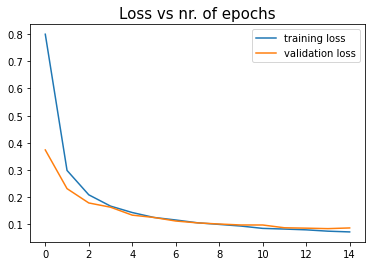

In [12]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.title("Loss vs nr. of epochs", fontsize = 15)
plt.legend()
plt.show()

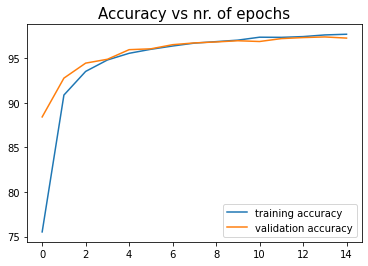

In [13]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.title("Accuracy vs nr. of epochs", fontsize = 15)
plt.legend()
plt.show()

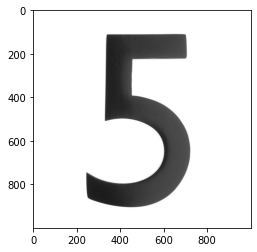

In [82]:
# Try to test the model on a figure showing the number 2

import requests
import PIL.ImageOps
from PIL import Image

url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
plt.show()

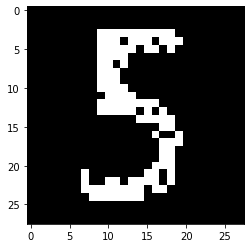

In [83]:
img = PIL.ImageOps.invert(img) # invert black and white
img = img.convert('1') # convert into a bilevel image
img = transformation(img) # resize into a 28x28x1 image, normalizing and scaling the image
plt.imshow(im_convert(img)) # show the image 

In [84]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


We aim at testing our model on figures showing the numbers 4, 8, 3, 2, 5, 1


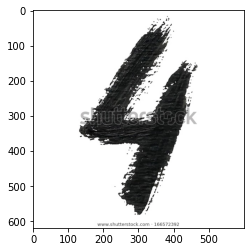

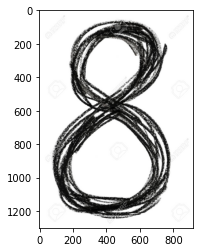

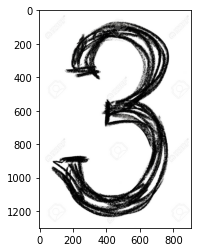

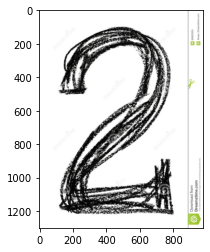

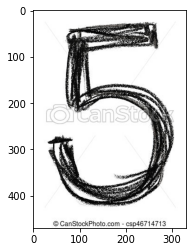

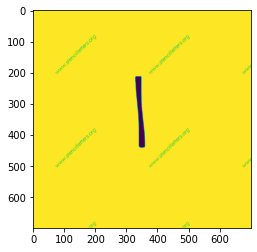

In [62]:
# Try to test the model on figures of handwritten digits. Some of them may contain noise like watermarks or text positioned 
# inside the image itself. This might help us understand how much the model is robust to noise and fluctuations

import requests
import PIL.ImageOps
from PIL import Image

urls = ["https://image.shutterstock.com/image-illustration/4-black-handwritten-number-on-600w-166572392.jpg",
        "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg",
        "https://previews.123rf.com/images/aroas/aroas1704/aroas170400051/79321944-handwritten-sketch-black-number-3-on-white-background.jpg",
        "https://thumbs.dreamstime.com/z/handwritten-sketch-black-number-white-background-90805304.jpg",
        "https://comps.canstockphoto.com/handwritten-sketch-black-number-5-picture_csp46714713.jpg",
        "https://stencilletters.org/1-12inch-stencils/134-cursive/numbers0-9/number-stencil-1.jpg"
]

imgs = []


for item in urls:
    response = requests.get(item, stream = True)
    imgs.append(Image.open(response.raw))

print("We aim at testing our model on the following figures, showing the numbers 4, 8, 3, 2, 5, 1")

fig = plt.figure(figsize=(25, 4)) 

for f in imgs:
    plt.imshow(f)
    plt.show()


In [76]:
numbs = [4, 8, 3, 2, 5, 1]

preds = []

np.random.seed(2)

for f in imgs:
    f = PIL.ImageOps.invert(f) # invert black and white
    f = f.convert('1')
    f = transformation(f)
    images = f.to(device)
    image = images[0].unsqueeze(0).unsqueeze(0)
    output = model(image)
    _, pred = torch.max(output, 1)
    preds.append(pred.item())


for i in range(len(numbs)):
    print("The number " + str(numbs[i]) + " gets predicted as "+ str(preds[i]))


The number 4 gets predicted as 4
The number 8 gets predicted as 8
The number 3 gets predicted as 3
The number 2 gets predicted as 2
The number 5 gets predicted as 5
The number 1 gets predicted as 6


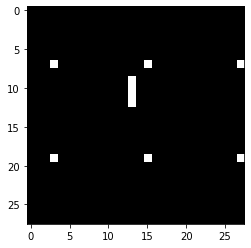

In [86]:
# Check how the misclassified image has been converted

imgs[5] = PIL.ImageOps.invert(imgs[5])
imgs[5] = imgs[5].convert("1")
imgs[5] = transformation(imgs[5])
plt.imshow(im_convert(imgs[5]))

**Conclusion**. The previous convolutional neural network seems to work well on most test data. It generally shows robustness to the presence of some noise too, like watermarks and text on figures. All of the test data but the last figure is correctly classified. The last image is misclassified and this could be due to two facts:
1. the sparse presence of many watermarks in some parts of the figure,
2. the size of the number 1 comparable to the size of the watermarks.

In spite of this, we could conclude that the performance of the model is nearly optimal.